# Project: Ambient Agents with LangGraph - Module 5: Memory

In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Agents with Memory

We have seen an email assitant that uses a router to triage emails and then passes the email to the agent for repsonse generation. We have also evaluated it and added human-in-the-loop (HITL) to review specific tool calls.

In this module, we will add memory, giving our assitant the ability to remember our HITL feedback.

# Memory in LangGraph

## Thread-Scoped and Across-Thread Memory

LangGraph supports two types of memory that serve complementary purposes:

- **Thread-Scoped Memory (Short-term)** operates within the boundaries of a single conversation thread. It is automatically managed as part of the graph's state and persisted through thread-scoped checkpoints. This memory type retains conversation history, uploaded files, retrieved documents, and other artifacts generated during the interaction.

- **Across-Thread Memory (Long-term)** extends beyond individual conversations, creating a persistent knowledge base that spans multiple sessions. This memory is stored as JSON documents in a memory store, organized by namespaces (*folders*) and distinct keys (*filenames*). Unlike thread-scoped memory, this information persists even after conversation ends, enabling the system to recall user preferences, past interactions, and accumulated knowledge over time.

The [**Store**](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) is the foundation of this architecture, providing a flexible database where memories can be organized, retrieved, and updated.

## LangGraph Store

LangGraph offers different Store implementations:

1. **In-Memory (e.g., notebooks)**:
    - Uses `from langgraph.store.memory import InMemoryStore`
    - Purely a Python dictionary in memory with no persistence
    - Data is lost when the process terminates
    - Useful for quick experiments and testing
    - Semantic search can be configured with [HERE](https://langchain-ai.github.io/langgraph/how-tos/memory/semantic-search/)

2. **Local Development with `langgraph dev`**:
    - Similar to `InMemoryStore` but with pseudo-persistence
    - Data is pickled to the local filesystem between restarts
    - Lightweight and fast, no need for external databases
    - Semantic search can be configured with [HERE](https://docs.langchain.com/langsmith/semantic-search)
    - Great for development but not designed for production use

3. **LangGraph Platform or Production Deployments**:
    - Uses PostgreSQL with pgvector for production-grade persistence
    - Fully persistent data storage with reliable backups
    - Scalable for larger datasets
    - Semantic search can be configured with [HERE](https://docs.langchain.com/langsmith/semantic-search)
    - Default distance metric is cosine similarity (customizable)

For example, we can use the `InMemoryStore` for quick experiments in a notebook:

In [2]:
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

Memories are namespaced by a tuple, which in this specific example will be `(<user_id>, "memories")`.

In [3]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

Then, we use the `store.put` method to save memories to our namespace in the store. When we do this, we specify the namespace, as defined above, and a key-value pair for the memory: the key simply a unique identifier for the memory (`memory_id`) and the value (a dictionary) is the memory content itself.

In [4]:
import uuid

memory_id = str(uuid.uuid4())
memory = {'food_preference': "I like Chinese food."}

in_memory_store.put(
    namespace_for_memory,
    memory_id,
    memory
)

We can read out memories in our namespace using the `store.search` method, which will return all memories for a given user as a list.

In [5]:
memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='721da1f5-b64a-460f-967e-f750a234f5eb', value={'food_preference': 'I like Chinese food.'}, created_at='2025-10-14T18:51:51.598210+00:00', updated_at='2025-10-14T18:51:51.598210+00:00', score=None)]

The most recent memory is the last in the list. Each memory type is a Python class (`Item`) with certain attributes. We can access it as a dictionary by converting via `.dict`.

In [6]:
most_recent_memory = memories[-1]
most_recent_memory.dict()

{'namespace': ['1', 'memories'],
 'key': '721da1f5-b64a-460f-967e-f750a234f5eb',
 'value': {'food_preference': 'I like Chinese food.'},
 'created_at': '2025-10-14T18:51:51.598210+00:00',
 'updated_at': '2025-10-14T18:51:51.598210+00:00',
 'score': None}

To use this in a graph, all we need to do is to compile the graph with the store:

In [ ]:
# We need this because we want to enable threads
from langgraph.checkpoint.memory import InMemorySaver
# We need this because we want to enable across-threads memory
from langgraph.store.memory import InMemoryStore

# Short-term memory
checkpointer = InMemorySaver()
# Long-term memory
in_memory_store = InMemoryStore()

# Compile the graph with the memories
#graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)

# Adding Memory to our Assitant

Now we will take our graph with HITL and add memory to it.

In [2]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.store.base import BaseStore
from langgraph.types import interrupt, Command

from email_assistant.prompts import (
    triage_system_prompt,
    triage_user_prompt,
    agent_system_prompt_hitl_memory,
    default_triage_instructions, 
    default_background, 
    default_response_preferences, 
    default_cal_preferences, 
    MEMORY_UPDATE_INSTRUCTIONS, 
    MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT
)
from email_assistant.tools.default.prompt_templates import HITL_MEMORY_TOOLS_PROMPT
from email_assistant.schemas import State, StateInput, RouterSchema
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

In [3]:
# Agent tools
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"


@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: datetime,
    start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"


@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"


@tool
class Question(BaseModel):
    """Question to ask user."""
    content: str


@tool
class Done(BaseModel):
    """Email has been sent."""
    done: bool


# All tools available to the agent
tools = [
    write_email,
    schedule_meeting,
    check_calendar_availability,
    Question,
    Done
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the chat model
llm = init_chat_model('openai:gpt-4.1', temperature=0)
# Initialize LLM with router / structured output
llm_router = llm.with_structured_output(RouterSchema)
# Initialize LLM, enforcing tool use
llm_with_tools = llm.bind_tools(tools, tool_choice='required')

## Memory Management

What we want to do is to add the feedback to the memory `Store`. If we compile our graph with the `Store, we can access it in any node.

To **structure the memory**, we will store memories as string to keep things simple. We will fetch memories from the store as string and initialize with default if it does not exist.

In [4]:
from rich.markdown import Markdown

Markdown(default_triage_instructions)

Emails that are not worth responding to:                                                                           

 • Marketing newsletters and promotional emails                                                                    
 • Spam or suspicious emails                                                                                       
 • CC'd on FYI threads with no direct questions                                                                    

There are also other things that should be known about, but don't require an email response. For these, you should 
notify (using the notify response). Examples of this include:                                                      

 • Team member out sick or on vacation                                                                             
 • Build system notifications or deployments                                                                       
 • Project status updates without action items                                                                     
 • Important company announcements                                                                                 
 • FYI emails that contain relevant information for current projects                                               
 • HR Department deadline reminders                                                                                
 • Subscription status / renewal reminders                                                                         
 • GitHub notifications                                                                                            

Emails that are worth responding to:                                                                               

 • Direct questions from team members requiring expertise                                                          
 • Meeting requests requiring confirmation                                                                         
 • Critical bug reports related to team's projects                                                                 
 • Requests from management requiring acknowledgment                                                               
 • Client inquiries about project status or features                                                               
 • Technical questions about documentation, code, or APIs (especially questions about missing endpoints or         
   features)                                                                                                       
 • Personal reminders related to family (wife / daughter)                                                          
 • Personal reminder related to self-care (doctor appointments, etc)

In [5]:
Markdown(default_cal_preferences)

30 minute meetings are preferred, but 15 minute meetings are also acceptable.

In [6]:
Markdown(default_response_preferences)    

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and  
reference the deadline in your response.                                                                           

When responding to technical questions that require investigation:                                                 

 • Clearly state whether you will investigate or who you will ask                                                  
 • Provide an estimated timeline for when you'll have more information or complete the task                        

When responding to event or conference invitations:                                                                

 • Always acknowledge any mentioned deadlines (particularly registration deadlines)                                
 • If workshops or specific topics are mentioned, ask for more specific details about them                         
 • If discounts (group or early bird) are mentioned, explicitly request information about them                     
 • Don't commit                                                                                                    

When responding to collaboration or project-related requests:                                                      

 • Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)                          
 • Explicitly mention reviewing these materials before or during the meeting                                       
 • When scheduling meetings, clearly state the specific day, date, and time proposed                               

When responding to meeting scheduling requests:                                                                    

 • If times are proposed, verify calendar availability for all time slots mentioned in the original email and then 
   commit to one of the proposed times based on your availability by scheduling the meeting. Or, say you can't make
   it at the time proposed.                                                                                        
 • If no times are proposed, then check your calendar for availability and propose multiple time options when      
   available instead of selecting just one.                                                                        
 • Mention the meeting duration in your response to confirm you've noted it correctly.                             
 • Reference the meeting's purpose in your response.

In [8]:
def get_memory(store, namespace, default_content=None):
    """Get memory from the store or initialize with default if not found.
    
    Args:
        store: LangGraph BaseStore instance to search for existing memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        default_content: Default content to use if memory doesn't exist
        
    Returns:
        str: The content of the memory profile, either from existing memory or the default
    """
    # Search for existing memory with namespace and key
    user_preferences = store.get(namespace, 'user_preferences')

    # If memory exists, return its content (the value)
    if user_preferences:
        return user_preferences.value
    
    # If no existing memory, add it to the store and return the default content
    else:
        # Namespace, key, value
        store.put(
            namespace,
            'user_preferences',
            default_content
        )
        user_preferences = default_content

    # Return the default content
    return user_preferences

To **update the memory**, we will use a few tricks form the [GPT-4.1 prompting guide](https://cookbook.openai.com/examples/gpt4-1_prompting_guide) to help us update the memory:
    - For optimal performance, repeat the key instructions at the start and end of the prompt.
    - Create clear, explicit instructions
    - Use XML delimiters for structure
    - Provide examples

In [9]:
Markdown(MEMORY_UPDATE_INSTRUCTIONS)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                               Role and Objective                                                ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

You are a memory profile manager for an email assistant agent that selectively updates user preferences based on   
feedback messages from human-in-the-loop interactions with the email assistant.                                    

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Instructions                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

 • NEVER overwrite the entire memory profile                                                                       
 • ONLY make targeted additions of new information                                                                 
 • ONLY update specific facts that are directly contradicted by feedback messages                                  
 • PRESERVE all other existing information in the profile                                                          
 • Format the profile consistently with the original style                                                         
 • Generate the profile as a string                                                                                

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                 Reasoning Steps                                                 ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

 1 Analyze the current memory profile structure and content                                                        
 2 Review feedback messages from human-in-the-loop interactions                                                    
 3 Extract relevant user preferences from these feedback messages (such as edits to emails/calendar invites,       
   explicit feedback on assistant performance, user decisions to ignore certain emails)                            
 4 Compare new information against existing profile                                                                
 5 Identify only specific facts to add or update                                                                   
 6 Preserve all other existing information                                                                         
 7 Output the complete updated profile                                                                             

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                     Example                                                     ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

<memory_profile> RESPOND:                                                                                          

 • wife                                                                                                            
 • specific questions                                                                                              
 • system admin notifications NOTIFY:                                                                              
 • meeting invites IGNORE:                                                                                         
 • marketing emails                                                                                                
 • company-wide announcements                   

In [11]:
Markdown(MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT)

Remember:                                                                                                          

 • NEVER overwrite the entire memory profile                                                                       
 • ONLY make targeted additions of new information                                                                 
 • ONLY update specific facts that are directly contradicted by feedback messages                                  
 • PRESERVE all other existing information in the profile                                                          
 • Format the profile consistently with the original style                                                         
 • Generate the profile as a string

In [12]:
class UserPreferences(BaseModel):
    """Updated user preferences based on user's feedback."""
    chain_of_thought: str = Field(
        description="Reasoning about which user preferences need to add / update if required"
    )
    user_preferences: str = Field(
        description="Updated user preferences"
    )


def update_memory(store, namespace, messages):
    """Update memory profile in the store.
    
    Args:
        store: LangGraph BaseStore instance to update memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        messages: List of messages to update the memory with
    """
    # Get the existing memory
    user_preferences = store.get(namespace, 'user_preferences')

    # Update the memory
    llm = init_chat_model('openai:gpt-4.1', temperature=0).with_structured_output(UserPreferences)
    result = llm.invoke(
        [{
            'role': 'system',
            'content': MEMORY_UPDATE_INSTRUCTIONS.format(current_profile=user_preferences.value, namespace=namespace)
        }] + messages
    )

    # Save the updated memory to the store
    store.put(
        namespace,
        'user_preferences',
        result.user_preferences
    )

We then set up the triage router as we had before with one small change:

In [13]:
def triage_router(state: State, store: BaseStore) -> Command[Literal['triage_interrupt_handler', 'response_agent', '__end__']]:
    """Analyze email content to decide if we should respond, notify, or ignore.
    
    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    # Parse the email content
    author, to, subject, email_thread = parse_email(state['email_input'])
    user_prompt = triage_user_prompt.format(
        author=author,
        to=to,
        subject=subject,
        email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification
    email_markdown = format_email_markdown(subject, author, to, email_thread)
    
    # Search for existing `triage_preferences` memory
    triage_instructions = get_memory(
        store,
        ('email_assistant', 'triage_preferences'),
        default_triage_instructions
    )

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=triage_instructions
    )

    # Run the router LLM
    result = llm_router.invoke([
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': user_prompt}
    ])

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == 'respond':
        print("Classification: RESPOND - This email requires a response.")
        goto = 'response_agent'
        update = {
            'classification_decision': classification,
            'messages': [{
                'role': 'user',
                'content': f"Respond to the email: {email_markdown}"
            }]
        }
    elif classification == 'ignore':
        print("Classification: IGNORE - This email can be safely ignored.")
        goto = END
        update = {
            'classification_decision': classification,
        }
    elif classification == 'notify':
        print("Classification: NOTIFY - This email contains important information.")
        goto = 'triage_interrupt_handler'
        update = {
            'classification_decision': classification
        }
    else:
        raise ValueError(f"Invalid classification: {classification}")
    
    return Command(goto=goto, update=update)

We only need to make a small change to the interrupt handler to update the memory when the user provides feedback.

In [14]:
def triage_interrupt_handler(state: State, store: BaseStore) -> Command[Literal['response_agent', '__end__']]:
    """Handle interrupts from the triage step"""
    # Parse the email input
    author, to, subject, email_thread = parse_email(state['email_input'])

    # Create email markdown for Agent Inbox in case of notification
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{
        'role': 'user',
        'content': f"Email to notify user about: {email_markdown}"
    }]

    # Create interrupt from Agent Inbox
    request = {
        'action_request': {
            'action': f"Email Assistant: {state['classification_decision']}",
            'args': {}
        },
        'config': {
            'allow_ignore': True,
            'allow_respond': True,
            'allow_edit': False,
            'allow_accept': False
        },
        # Email to show in Agent Inbox
        'description': email_markdown
    }

    # Send to Agent Inbox and wait for resopnse
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feed back to respond to email
    if response['type'] == 'response':
        # Add feedback to messages
        user_input = response['args']
        messages.append({
            'role': 'user',
            'content': f"User wants to reply to the email. Use this feedback to respond: {user_input}"
        })
        # NEW THING: update `triage_preferences` memory with user feedback
        update_memory(
            store,
            ('email_assistant', 'triage_preferences'),
            [{
                'role': 'user',
                'content': f"The user decided to respond to the email, so update the triage preferences to capture this."
            }] + messages
        )
    # If user ignores email, go to END
    elif response['type'] == 'ignore':
        # Make note of the user's decision to ignore the email
        messages.append({
            'role': 'user',
            'content': f"The user decided to ignore the email even though it was classified as notify. Update triage preferences to capture this."
        })
        # NEW THING: update `triage_preferences` memory with user feedback
        update_memory(
            store,
            ('email_assistant', 'triage_preferences'),
            messages
        )
        goto = END
    
    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")
    
    # Update the state
    update = {'messages': messages}

    return Command(goto=goto, update=update)

## Incorporating Memory into LLM Responses

Now that we have memory managers set up, we can use the stored preferences when generating responses in our LLM agent.

In [15]:
def llm_call(state: State, store: BaseStore):
    """LLM decides whether to call a tool"""
    # Search for existing `cal_preferences` memory
    cal_preferences = get_memory(
        store,
        ('email_assistant', 'cal_preferences'),
        default_cal_preferences
    )

    # Search for existing `response_preferences` memory
    response_preferences = get_memory(
        store,
        ('email_assistant', 'response_preferences'),
        default_response_preferences
    )

    return {
        'messages': [
            llm_with_tools.invoke(
                [
                    {
                        'role': 'system',
                        'content': agent_system_prompt_hitl_memory.format(
                            tools_prompt=HITL_MEMORY_TOOLS_PROMPT,
                            background=default_background,
                            response_preferences=response_preferences,
                            cal_preferences=cal_preferences
                        )
                    }
                ]
                + state['messages']
            )
        ]
    }

## Memory Integration in the Interrupt Handler

Similarly, we will add memory to the interrupt handler:

In [17]:
def interrupt_handler(state: State, store: BaseStore) -> Command[Literal['llm_call', '__end__']]:
    """Create an interrupt for human review of tool calls"""
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = 'llm_call'

    # Iterate over the tool calls in the last message
    for tool_call in state['messages'][-1].tool_calls:
        # Allowed tools for HITL
        hitl_tools = ['write_email', 'schedule_meeting', 'Question']

        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call['name'] not in hitl_tools:
            # Execute tool without interruption
            tool = tools_by_name[tool_call['name']]
            observation = tool.invoke(tool_call['args'])
            result.append({
                'role': 'tool',
                'content': observation,
                'tool_call_id': tool_call['id']
            })
            continue

        # Get original email from email_input in state
        email_input = state['email_input']
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)

        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # configure what actions are allowed in Agent Inbox
        if tool_call['name'] == 'write_email':
            config = {
                'allow_ignore': True,
                'allow_respond': True,
                'allow_edit': True,
                'allow_accept': True
            }
        elif tool_call['name'] == 'schedule_meeting':
            config = {
                'allow_ignore': True,
                'allow_respond': True,
                'allow_edit': True,
                'allow_accept': True
            }
        elif tool_call['name'] == 'Question':
            config = {
                'allow_ignore': True,
                'allow_respond': True,
                'allow_edit': False,
                'allow_accept': False
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")
        
        # Create the interrupt request
        request = {
            'action_request': {
                'action': tool_call['name'],
                'args': tool_call['args']
            },
            'config': config,
            'description': description
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the response
        if response['type'] == 'accept':
            # Execute the tool with original args
            tool = tools_by_name[tool_call['name']]
            observation = tool.invoke(tool_call['args'])
            result.append({
                'role': 'tool',
                'content': observation,
                'tool_call_id': tool_call['id']
            })
        elif response['type'] == 'edit':
            # Tool selection
            tool = tools_by_name[tool_call['name']]
            initial_tool_call = tool_call['args']

            # Get edited args from Agent Inbox
            edited_args = response['args']['args']

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state['messages'][-1] # Get the most recent message from the state
            current_id = tool_call['id'] # Store the ID of the tool call being edited

            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [
                tc for tc in ai_message.tool_calls if tc['id'] != current_id
            ] + [
                {'type': 'tool_call', 'name': tool_call['name'], 'args': edited_args, 'id': current_id}
            ]

            # Create a new copy of the message with updated tool calls rather than modifying the original.
            # This ensures state immutability and prevents side effects in other parts of the code.
            # When we update the messages state key ('messages': result), the `add_messages` reducer will overwrite
            # the existing messages by id and we take advantage of this here to update the tool calls.
            result.append(
                ai_message.model_copy(update={'tool_calls': updated_tool_calls})
            )

            # Save feedback in memory and update the `write_email` tool call with the edited content from Agent Inbox
            if tool_call['name'] == 'write_email':
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                # Add only the tool response message
                result.append({
                    'role': 'tool',
                    'content': observation,
                    'tool_call_id': current_id
                })
                # NEW THING: update the memory
                update_memory(
                    store,
                    ('email_assistant', 'response_preferences'),
                    [{
                        'role': 'user',
                        'content': f"User edited the email response. Here is the initial email generated by the assistant: {initial_tool_call}. Here is the edited email: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                    }]
                )

            # Save feedback in memory and update the `schedule_meeting` tool call with the edited content from Agent Inbox
            elif tool_call['name'] == 'schedule_meeting':
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)

                # Add only the tool response message
                result.append({
                    'role': 'tool',
                    'content': observation,
                    'tool_call_id': current_id
                })

                # NEW THING: update the memory
                update_memory(
                    store,
                    ('email_assistant', 'cal_preferences'),
                    [{
                        'role': 'user',
                        'content': f"User edited the calendar invitation. Here is the initial calendar invitation generated by the assistant: {initial_tool_call}. Here is the edited calendar invitation: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                    }]
                )

            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
        elif response['type'] == 'ignore':
            
            if tool_call['name'] == 'write_email':
                # Do not execute the tool, and tell the agent how to proceed
                result.append({
                    'role': 'tool',
                    'content': "User ignored this email draft. Ignore this email and end the workflow.",
                    'tool_call_id': tool_call['id']
                })
                # Go to END
                goto = END
                # NEW THING: update the memory
                update_memory(
                    store,
                    ('email_assistant', 'triage_preferences'),
                    state['messages'] + result + [{
                        'role': 'user',
                        'content': f"The user ignored the email draft. That means they did not want to respond to the email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                    }]
                )

            elif tool_call['name'] == 'schedule_meeting':
                # Do not execute the tool, and tell the agent how to proceed
                result.append({
                    'role': 'tool',
                    'content': "User ignored this calendar meeting draft. Ignore this email and end the workflow.",
                    'tool_call_id': tool_call['id']
                })
                # Go to END
                goto = END
                # NEW THING: update the memory
                update_memory(
                    store,
                    ('email_assistant', 'triage_preferences'),
                    state['messages'] + result + [{
                        'role': 'user',
                        'content': f"The user ignored the calendar meeting draft. That means they did not want to schedule a meeting for this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                    }]
                )

            elif tool_call['name'] == 'Question':
                # Do not execute the tool, and tell the agent how to proceed
                result.append({
                    'role': 'tool',
                    'content': "User ignored this question. Ignore this email and end the workflow.",
                    'tool_call_id': tool_call['id']
                })
                # Go to END
                goto = END
                # NEW THING: update the memory
                update_memory(
                    store,
                    ('email_assistant', 'triage_preferences'),
                    state['messages'] + result + [{
                        'role': 'user',
                        'content': f"The user ignored the Question. That means they did not want to answer the question or deal with this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                    }]
                )

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
        elif response['type'] == 'response':
            # User provided feedback
            user_feedback = response['args']

            if tool_call['name'] == 'response':
                # Do not execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({
                    'role': 'tool',
                    'content': f"User gave feedback, which we can incorporate into the email. Feedback: {user_feedback}",
                    'tool_call_id': tool_call['id']
                })
                # NEW THING: update the memory
                update_memory(
                    store,
                    ('email_assistant', 'response_preferences'),
                    state['messages'] + result + [{
                        'role': 'user',
                        'content': f"User gave feedback, which we can use to update the response preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                    }]
                )

            elif tool_call['name'] == 'schedule_meeting':
                # Do not execute the tool, and add a message with the user feedback to incorporate into the calendar meeting
                result.append({
                    'role': 'tool',
                    'content': f"User gave feedback, which we can incorporate into the meeting request. Feedback: {user_feedback}",
                    'tool_call_id': tool_call['id']
                })
                # NEW THING: update the memory
                update_memory(
                    store,
                    ('email_assistant', 'cal_preferences'),
                    state['messages'] + result + [{
                        'role': 'user',
                        'content': f"User gave feedback, which we can use to update the calendar preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                    }]
                )

            elif tool_call['name'] == 'Question':
                # Do not execute the tool, and add a message with the user feedback to incorporate into the question response
                result.append({
                    'role': 'tool',
                    'content': f"User answered the question, which we can use for any follow up actions. Feedback: {user_feedback}.",
                    'tool_call_id': tool_call['id']
                })

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
    # Update the state
    update = {'messages': result}

    return Command(goto=goto, update=update)

The rest is the same as before.

In [18]:
from email_assistant.utils import show_graph

# Conditional edge function
def should_continue(state: State, store: BaseStore) -> Literal['interrupt_handler', END]:
    """Route to tool handler, or end if Done tool was called."""
    messages = state['messages']
    last_message = messages[-1]

    if last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == 'Done':
                return END
            else:
                return 'interrupt_handler'

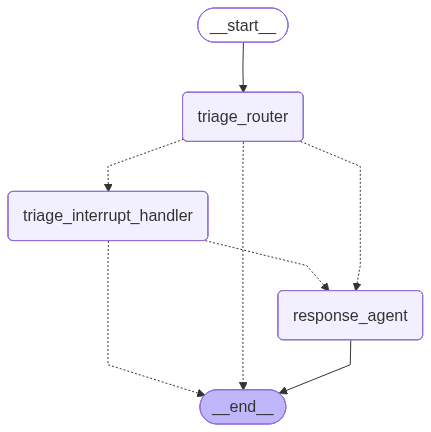

In [21]:
# Build workflow graph
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node('llm_call', llm_call)
agent_builder.add_node('interrupt_handler', interrupt_handler)

# Add edges
agent_builder.add_edge(START, 'llm_call')
agent_builder.add_conditional_edges(
    'llm_call',
    should_continue,
    {
        'interrupt_handler': 'interrupt_handler',
        END: END
    }
)

# Compile
response_agent = agent_builder.compile()

# Build overall workflow with store and checkpointer
overall_workflow = (
    StateGraph(State, input_schema=StateInput)
    .add_node('triage_router', triage_router)
    .add_node('triage_interrupt_handler', triage_interrupt_handler)
    .add_node('response_agent', response_agent)
    .add_edge(START, 'triage_router')
)

email_assistant = overall_workflow.compile()
show_graph(email_assistant)

# Testing the agent with Memory

Now that we have implemented memory into our email assistant, we can test how the system learns from user feedback and adapts over time.

To start, we need a helper function to display memory content so we can track how it evolves with user interactions.

In [22]:
import uuid
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command
from langgraph.store.memory import InMemoryStore


# Helper function to display memory content
def display_memory_content(store, namespace=None):
    # Display current memory content for all namespaces
    print("\n======= CURRENT MEMORY CONTENT =======")
    if namespace:
        memory = store.get(namespace, 'user_preferences')
        print(f"\n--- {namespace[1]} ---")
        if memory:
            print(memory.value)
        else:
            print("No memory found.")
    else:
        for namespace in [
            ('email_assistant', 'triage_preferences'),
            ('email_assistant', 'response_preferences'),
            ('email_assistant', 'cal_preferences'),
            ('email_assistant', 'background')
        ]:
            memory = store.get(namespace, 'user_preferences')
            print(f"\n--- {namespace[1]} ---")
            if memory:
                print(memory.value)
            else:
                print("No memory found.")
            print("======================================\n")

## Accept `write_email` and `schedule_meeting`

This test demonstrates the default behavior of our memory-enabled system. When a user simply accepts proposed actions, we expect minimal or no memory updates since there's no explicit feedback to learn from. However, the system will still leverage existing memory (if any) when generating its responses.

In [23]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Bin Liu <bin@company.ai>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Bin,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_1 = uuid.uuid4()
thread_config_1 = {'configurable': {'thread_id': thread_id_1}}


# Run the graph until the first interrupt
# Email will be classified as "respond"
# Agent will create a `schedule_meeting` and `write_email` tool calls
print("Running the graph until the first interrupt...")
for chunk in graph.stream(
    {'email_input': email_input_respond},
    config=thread_config_1
):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store)

Running the graph until the first interrupt...
Classification: RESPOND - This email requires a response.

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-10-21', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadlin

Next, we will accept the `schedule_meeting` tool call.

After running this step, we will check the memory contents to confirm whether acceptance alone leads to memory updates. Simple acceptance represents the baseline user experience - the system works as intended without requiring adjustments.

In [24]:
print(f"\nSimulating user accepting the {interrupt_obj.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(
    Command(resume=[{'type': 'accept'}]),
    config=thread_config_1
):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I am available on Tuesday, October 21st at 2:00 PM for a 45-minute call to discuss tax planning strategies. I have scheduled this time on my calendar.\n\nIf you have any materials or suggestions you’d like me to review ahead of time, please feel free to send them over.\n\nLooking forward to our discussion.\n\nBest regards,\nBin'}}


Next, we will accept the `write_email` tool call.

After accepting, we will check all memory stored to see if any updates occurred. As expected, simply accepting the agent's proposals does not provide strong learning signals - there is no clear feedback about what the user likes or dislikes about the agent's approach.

The trace link shows the complete workflow execution, where we can see that the memory is used in the LLM call for response generation, but no memory updates occur, which is the expected behavior for simple acceptance.

In [25]:
print(f"\nSimulating user accepting the {interrupt_obj.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(
    Command(resume=[{'type': 'accept'}]),
    config=thread_config_1
):
    # Inspect `response_agent` most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")


# Check memory after accepting the `write_email` tool call
display_memory_content(store)


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_UfSq10GPGRylHutw2exzDPZj)
 Call ID: call_UfSq10GPGRylHutw2exzDPZj
  Args:
    done: True

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails

We see that memory is used in the LLM call to respond, but the memory store is not updated, because we have not added any feedback via the HITL.

In [26]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Bin Liu <bin@company.ai>

Bin,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_nENHKWDZqAg8Br4v87fhd9tD)
 Call ID: call_nENHKWDZqAg8Br4v87fhd9tD
  Args:
    day: 2025-10-21
  check_calendar_availability (call_qf8nD4li6iCeE9Ag0MK2CAsX)
 Call ID: call_qf8nD4li6iCeE9Ag0MK2CAsX
  Args:
    day: 2025-10-23
================================= Tool Message =================================

Available tim

## Edit `write_email` and `schedule_meeting`

This test explores how the system learns from direct edits to its proposed actions. When users modify the agent's suggestions, it provides clear and specific learning signals about their preferences.

Edits provide the most explicit feedback about user preferences, letting the system learn exactly what changes are desired. We expect to see specific, targeted updates to our memory stores that reflect these edits.

In [30]:
# Same email as before
email_input_respond = {
    "to": "Bin Liu <bin@company.ai>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Bin,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_2 = uuid.uuid4()
thread_config_2 = {'configurable': {'thread_id': thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a `write_email` tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream(
    {'email_input': email_input_respond},
    config=thread_config_2
):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store, ('email_assistant', 'cal_preferences'))

Running the graph until the first interrupt...
Classification: RESPOND - This email requires a response.

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-10-21', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

30 minute meetings are preferred, but 15 minute meetings are also acceptable.



Edit the `schedule_meeting` tool call.

When we edit the meeting proposal, we have provided direct, explicit feedback about our preferences. This creates a significant learning opportunity for the system to update its memory accordingly.

After the edit, we will check the calendar preferences memory store to see how it is updated.

In [31]:
# Simulate user editing the `schedule_meeting` tool call
print(f"\nSimulating user editing the `schedule_meeting` tool call...")
edited_schedule_args = {
    'attendees': ['pm@client.com', 'bin@company.ai'],
    'subject': 'Tax Planning Discussion',
    'duration_minutes': 30, # changed from 45 to 30
    'preferred_day': '2025-04-22',
    'start_time': 14
}

for chunk in graph.stream(
    Command(resume=[{'type': 'edit', 'args': {'args': edited_schedule_args}}]),
    config=thread_config_2
):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()

    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")

# Check memory after editing the `schedule_meeting` tool call
print("\nChecking memory after editing the `schedule_meeting`:")
display_memory_content(store, ('email_assistant', 'cal_preferences'))


Simulating user editing the `schedule_meeting` tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Dear Project Manager,\n\nThank you for reaching out regarding tax planning strategies. I am available next week and have scheduled a 30-minute call for Tuesday, October 21st at 2:00 PM. If you require the full 45 minutes, please let me know and I can adjust the timing accordingly.\n\nLooking forward to discussing your suggestions.\n\nBest regards,\nBin'}}

Checking memory after editing the `schedule_meeting`:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
30 minute meetings are preferred. 15 minute meetings are also acceptable. 45 minute meetings are not preferred.


Looking at the memory after editing the calendar invitation, we can see that it has been updated:
- The system has identified that we prefer 30-minute meetings over longer durations
- It has also captured our preference for concise meeting subjects


Next, we will edit the email draft to see how the system captures different types of communication preferences:

In [33]:
display_memory_content(store, ('email_assistant', 'response_preferences'))

# Now simulate user editing the `write_email` tool call
print("\nSimulating user editing the `write_email` tool call...")
edited_email_args = {
    'to': 'pm@client.com',
    'subject': "Re: Tax season let's schedule call",
    'content': "Thanks! I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nBin"
}

for chunk in graph.stream(
    Command(resume=[{'type': 'edit', 'args': {'args': edited_email_args}}]),
    config=thread_config_2
):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()

    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")

# Check memory after editing the `write_email` tool call
print("\nChecking memory after editing the `write_email`:")
display_memory_content(store, ('email_assistant', 'response_preferences'))


======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
- Explicitly mention reviewing these materials before or durin

Our email edit reveals more sophisticated learning:
- dramatically shortened and simplified the email content
- changed the tone to be more casual
- added a question asking for confirmation rather than assuming the time works
- slightly altered the meeting details (day and time)

In [34]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Bin Liu <bin@company.ai>

Bin,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_4QeinAw5j0bdvYuHRLvYKMZK)
 Call ID: call_4QeinAw5j0bdvYuHRLvYKMZK
  Args:
    day: 2025-10-21
  check_calendar_availability (call_AHtcN3VpvoNUtb7I7G26uR0r)
 Call ID: call_AHtcN3VpvoNUtb7I7G26uR0r
  Args:
    day: 2025-10-23
================================= Tool Message =================================

Available tim

## Respond (with feedback) `write_email` and `schedule_meeting`

Our final test set explores the "response" feedback pattern - providing guidance without directly editing or accepting. This conversational feedback mechanism offers a middle ground between acceptance and editing.

In [35]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Bin Liu <bin@company.ai>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Bin,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_3 = uuid.uuid4()
thread_config_3 = {"configurable": {"thread_id": thread_id_3}}

# Run the graph until the first interrupt
# Email will be classified as "respond"
# Agent will create a `schedule_meeting` and `write_email` tool calls
print("Running the graph until the first interrupt...")
for chunk in graph.stream(
    {'email_input': email_input_respond},
    config=thread_config_3
):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store, ('email_assistant', 'cal_preferences'))

Running the graph until the first interrupt...
Classification: RESPOND - This email requires a response.

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-10-21', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

30 minute meetings are preferred, but 15 minute meetings are also acceptable.



Provide feedback for the `schedule_meeting` tool call.

In [36]:
print(f"\nSimulating user providing feedback for the {interrupt_obj.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(
    Command(resume=[{'type': 'response', 'args': 'Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm.'}]),
    config=thread_config_3
):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")

    
# Check memory after providing feedback for the `schedule_meeting` tool call
print("\nChecking memory after providing feedback for the `schedule_meeting` tool call:")
display_memory_content(store, ('email_assistant', 'cal_preferences'))


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-10-21', 'start_time': 14}}

Checking memory after providing feedback for the `schedule_meeting` tool call:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

30 minute meetings are preferred, but 15 minute meetings are also acceptable.
Afternoon meetings after 2pm are preferred.



Our memory check after providing feedback shows an elegantly simple calendar preference update.

Next we accept this revised meeting proposal and move to the email draft.

In [37]:
print(f"\nSimulating user ignoring the {interrupt_obj.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(
    Command(resume=[{'type': 'accept'}]),
    config=thread_config_3
):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")


# Check memory after accepting the `schedule_meeting` tool call
print("\nChecking memory after accepting the `schedule_meeting` tool call:")
display_memory_content(store, ('email_assistant', 'response_preferences'))


Simulating user ignoring the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hello,\n\nThank you for reaching out. I have scheduled a 30-minute call for us on Tuesday, October 21st at 2:00 PM to discuss tax planning strategies for this year. If you have any specific topics or documents you'd like to cover, please let me know in advance.\n\nLooking forward to our discussion.\n\nBest regards,\nBin"}}

Checking memory after accepting the `schedule_meeting` tool call:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for

Now we provide feedback for the `write_email` tool call.

In [ ]:
print(f"\nSimulating user providing feedback for the {interrupt_obj.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(
    Command(resume=[{'type': 'response', 'args': "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]),
    config=thread_config_3
):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()

    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")


# Check memory after providing feedback for the `write_email` tool call
print("\nChecking memory after providing feedback for the `write_email` tool call:")
display_memory_content(store, ('email_assistant', 'response_preferences'))

In [ ]:
print(f"\nSimulating user accepting the {interrupt_obj.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(
    Command(resume=[{'type': 'accept'}]),
    config=thread_config_3
):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        interrupt_obj = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {interrupt_obj.value[0]['action_request']}")


# # Check memory after accepting the `write_email` tool call
print("\nChecking memory after accepting the `write_email` tool call:")
display_memory_content(store, ('email_assistant', 'response_preferences'))

In [ ]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()